#  Image Colorization for Improved JPEG
In extreme JPEG compression, Cb and Cr can be decimated by the factor of 4 or 8 i.e. their pixel area is 1
16
and 1
64 that of Y respectively. Thus one can consider,
almost all color information is lost and estimating that
back is almost the problem of image colorization from
gray image (i.e. Y channel). For transmission over low bandwidth network, the colorful image flyingelephant.jpg is extremely decimated in both Cb and Cr channels, whereas original Y channel is preserved, as shown in Fig. 3. Thus inputs available are Y channel and extremely decimated (very small size) Cb and Cr channels, from which the original colorful image
flyingelephant.jpg need to be estimated.

In [18]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [19]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

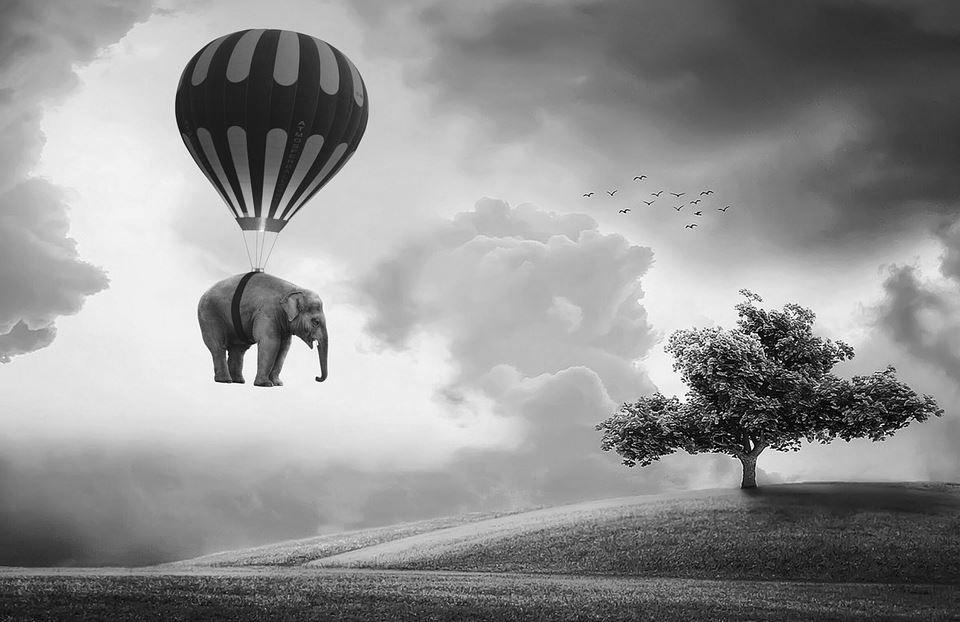

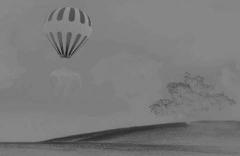

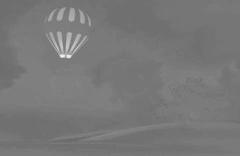

In [20]:
path1 = "/content/Y.jpg"
path2 = "/content/Cb4.jpg"
path3 = "/content/Cr4.jpg"
Y = cv2.imread(path1,0)
Cb4 = cv2.imread(path2,0)
Cr4 = cv2.imread(path3,0)
cv2_imshow(Y)
cv2_imshow(Cb4)
cv2_imshow(Cr4)

In [21]:
print(Cb4.shape)
print(Cr4.shape)
print(Y.shape)

(156, 240)
(156, 240)
(622, 960)


In [22]:
size_kernel = 5
sigma_s = 70
sigma_r = 15
p = size_kernel-1

In [23]:
def padded_img(image,size_kernel):
  """function to pad the image"""
  pad_img = np.zeros((image.shape[0]+p,image.shape[1]+p))
  for i in range(int(p/2),image.shape[0]+int(p/2)):
    for j in range(int(p/2),image.shape[1]+int(p/2)):
      pad_img[i,j] = image[i-int(p/2),j-int(p/2)]
  return pad_img

In [24]:
def spatial_kernel(sigma_s,size_kernel):
  """function to expand the space of Cb and Cr images"""
  s_kernel = np.zeros((size_kernel,size_kernel))
  m = int(size_kernel/2)
  for i in range(size_kernel):
    for j in range(size_kernel):
      s_kernel[i,j] = np.exp(-0.5*(1/(4*sigma_s)**2)*((i-m)**2+(j-m)**2))
  return s_kernel

In [25]:
def range_kernel(sigma_r,size_kernel,img):
  """function to expand the range of Cb and Cr images"""
  r_kernel = np.zeros((size_kernel,size_kernel))
  m = int(size_kernel/2)
  for i in range(size_kernel):
    for j in range(size_kernel):
      r_kernel[i,j] = np.exp(-0.5*(1/(sigma_r)**2)*(img[i,j]-img[m,m])**2)
  return r_kernel

In [26]:
def joint_bilateral_unsampling(I,S):
  """de-convolving the image"""
  S_out = np.zeros(I.shape)
  I_pad = padded_img(I,size_kernel)
  s_kernel = spatial_kernel(sigma_s,size_kernel)
  for i in range(int(p/2),I.shape[0]+int(p/2)):
    for j in range(int(p/2),I.shape[1]+int(p/2)):
      img2 = I_pad[i-int(p/2):i+int(p/2)+1,j-int(p/2):j+int(p/2)+1]
      r_kernel = range_kernel(sigma_r,size_kernel,img2)
      mat1 = S[int((i-int(p/2))/4),int((j-int(p/2))/4)]*s_kernel
      S_out[i-int(p/2),j-int(p/2)] = np.sum(np.multiply(mat1,r_kernel))/np.sum(np.multiply(r_kernel,s_kernel))
  return S_out

In [27]:
def output(path1,path2,path3):
  """converting YCbCr to rgb images"""
  Y = cv2.imread(path1,0)
  Cb4 = cv2.imread(path2,0)
  Cr4 = cv2.imread(path3,0)
  S_out_Cb4 = joint_bilateral_unsampling(Y,Cb4)
  S_out_Cr4 = joint_bilateral_unsampling(Y,Cr4)
  output = np.zeros((Y.shape[0],Y.shape[1],3))
  output[:,:,0] = Y
  output[:,:,2] = S_out_Cb4
  output[:,:,1] = S_out_Cr4
  rgbout = ycbcr2rgb(output)
  return rgbout

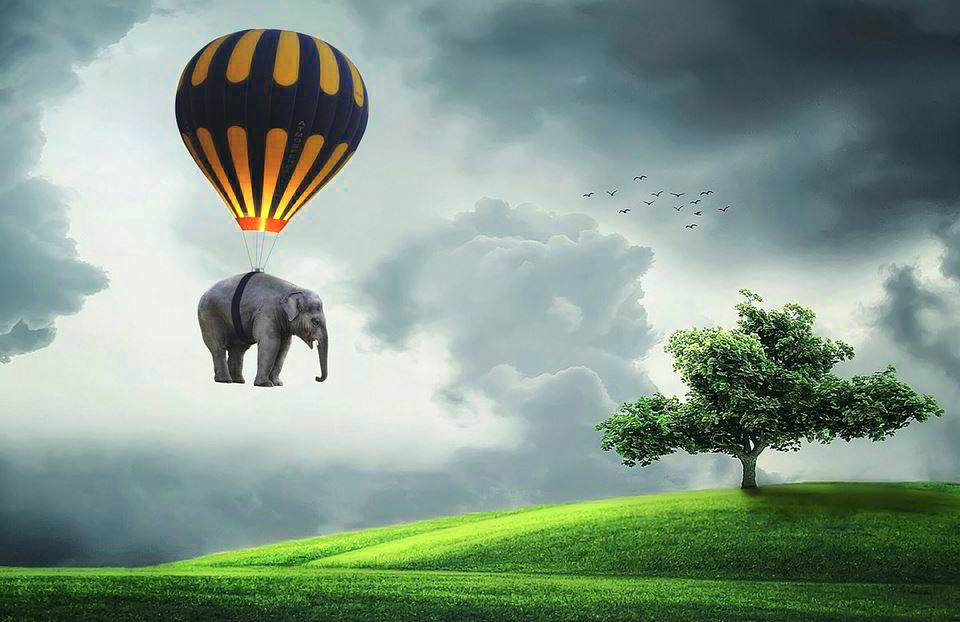

In [29]:
rgbout = output(path1,path2,path3)
plt.imsave('flyingelephant.jpg', rgbout)
cv2_imshow(rgbout)